In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import tqdm
import matplotlib.pyplot as plt

from utils import generate_dataset

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.dense(x)


class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, hidden_layers=[512, 512], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        
        self.fc1 = nn.Linear(2, embed_dim)
        
        layers = []
        prev_dim = embed_dim #+ embed_dim  
        for hidden_dim in hidden_layers:
            layers.append(Dense(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        layers.append(Dense(prev_dim, 2))  # Output is a 2D point
        
        self.layers = nn.Sequential(*layers)
        self.marginal_prob_std = marginal_prob_std
        
    def forward(self, x, t):
        embed = self.embed(t)
        x = self.fc1(x)
        #x = torch.cat([x, embed], dim=-1)
        x = torch.add(x, embed)
        h = self.layers(x)
        
        h = h / self.marginal_prob_std(t)[:, None]
        return h
'''
class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, embed_dim=256, p=0.3, device='cpu'):
        super().__init__()
        self.device = device
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
        
        self.linear_model1 = nn.Sequential(
                    nn.Linear(2, 256),
                    nn.Dropout(p),
                    nn.GELU(),
                )
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 512),
            nn.Dropout(p),
            nn.GELU(),
            
            nn.Linear(512, 2),
        )
        self.marginal_prob_std = marginal_prob_std
        self.to(device = self.device)
        
    def forward(self, x, t):
        embed = self.embed(t)
        output = self.linear_model1(x)
        h = self.linear_model2(output + embed)
        h = h / self.marginal_prob_std(t)[:, None]
        return h
'''

"\nclass ScoreNet(nn.Module):\n    def __init__(self, marginal_prob_std, embed_dim=256, p=0.3, device='cpu'):\n        super().__init__()\n        self.device = device\n        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),\n                                   nn.Linear(embed_dim, embed_dim))\n        \n        self.linear_model1 = nn.Sequential(\n                    nn.Linear(2, 256),\n                    nn.Dropout(p),\n                    nn.GELU(),\n                )\n        \n        self.linear_model2 = nn.Sequential(\n            nn.Linear(256, 512),\n            nn.Dropout(p),\n            nn.GELU(),\n            \n            nn.Linear(512, 512),\n            nn.Dropout(p),\n            nn.GELU(),\n            \n            nn.Linear(512, 2),\n        )\n        self.marginal_prob_std = marginal_prob_std\n        self.to(device = self.device)\n        \n    def forward(self, x, t):\n        embed = self.embed(t)\n        output = self.linear_model1(

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_interval = 1000
scatter_range = [-0.5, 0.5]
num_steps = 1000

n_epochs =  40000
## size of a mini-batch
batch_size =  512 
## learning rate
lr = 5e-4 


In [4]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

In [5]:
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=1500, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
      score_model: A PyTorch model that represents the time-dependent score-based model.
      marginal_prob_std: A function that gives the standard deviation of
        the perturbation kernel.
      diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
      batch_size: The number of samplers to generate by calling this function once.
      num_steps: The number of sampling steps.
        Equivalent to the number of discretized time steps.
      device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
      eps: The smallest time step for numerical stability.

    Returns:
      Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
    return mean_x

In [6]:
signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  1000#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cpu',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns: 
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 2, device=device) * marginal_prob_std(t)[:, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  imgs = [x]
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)      
      imgs.append(x)
    # The last step does not include any noise
    return x_mean, imgs

In [7]:
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [8]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
      model: A PyTorch model instance that represents a 
        time-dependent score-based model.
      x: A mini-batch of training data.    
      marginal_prob_std: A function that gives the standard deviation of 
        the perturbation kernel.
      eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss


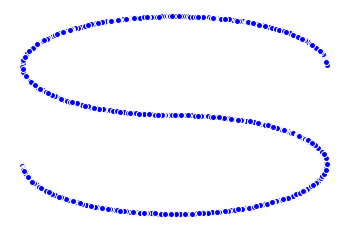

/var/folders/n_/ykwl_b5n0gx9x4hp5z0fmvvr0000gn/T/ipykernel_96561/3102636545.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.utils.data.TensorDataset(torch.tensor(data, device=device))


  0%|          | 0/40000 [00:00<?, ?it/s]

/var/folders/n_/ykwl_b5n0gx9x4hp5z0fmvvr0000gn/T/ipykernel_96561/2707645364.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/n_/ykwl_b5n0gx9x4hp5z0fmvvr0000gn/T/ipykernel_96561/2707645364.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


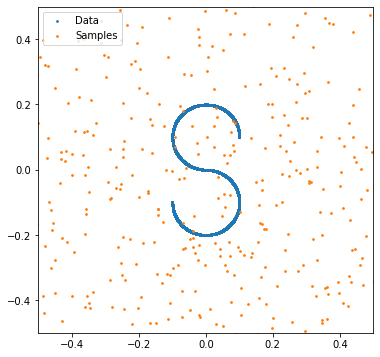

  0%|          | 0/1000 [00:00<?, ?it/s]

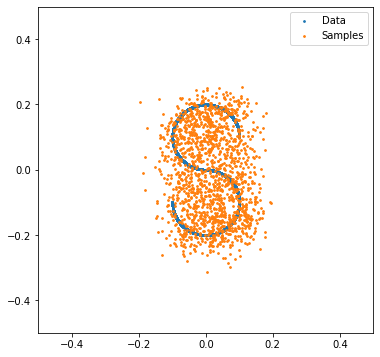

  0%|          | 0/1000 [00:00<?, ?it/s]

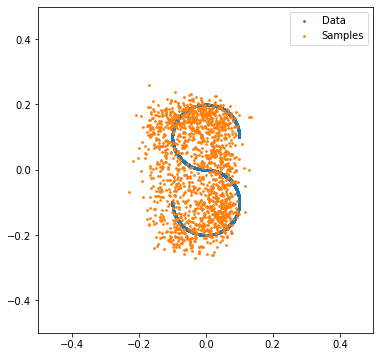

  0%|          | 0/1000 [00:00<?, ?it/s]

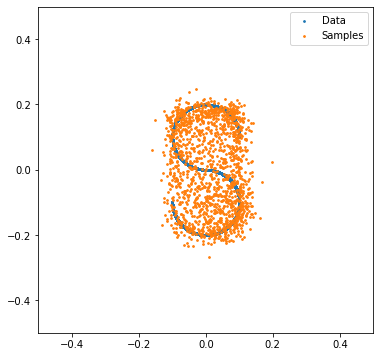

  0%|          | 0/1000 [00:00<?, ?it/s]

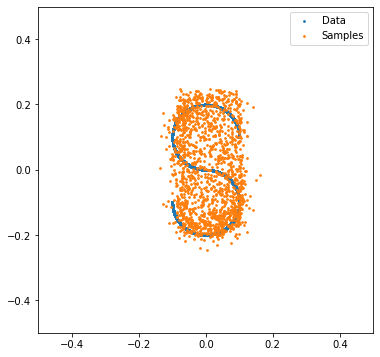

  0%|          | 0/1000 [00:00<?, ?it/s]

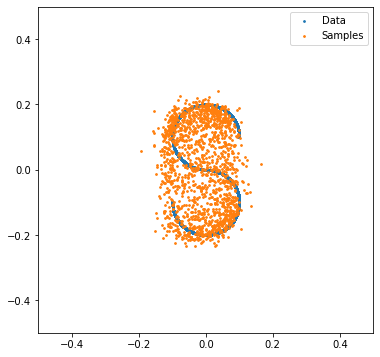

  0%|          | 0/1000 [00:00<?, ?it/s]

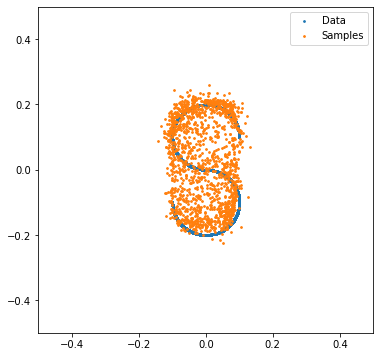

  0%|          | 0/1000 [00:00<?, ?it/s]

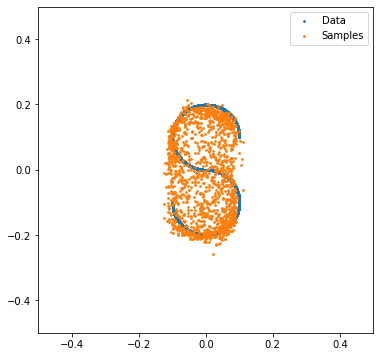

  0%|          | 0/1000 [00:00<?, ?it/s]

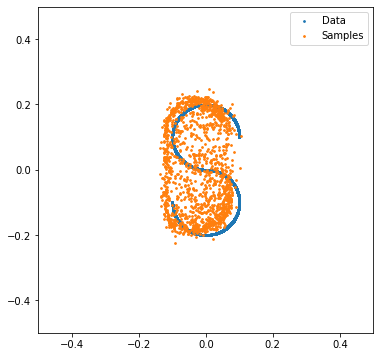

  0%|          | 0/1000 [00:00<?, ?it/s]

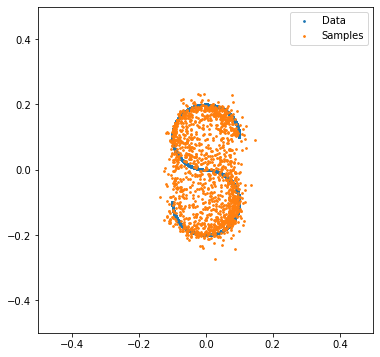

  0%|          | 0/1000 [00:00<?, ?it/s]

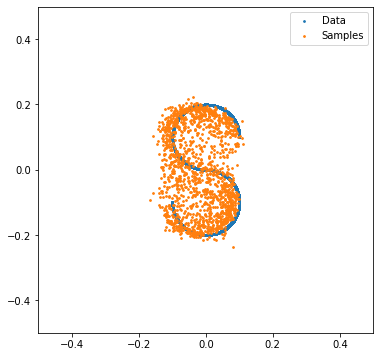

  0%|          | 0/1000 [00:00<?, ?it/s]

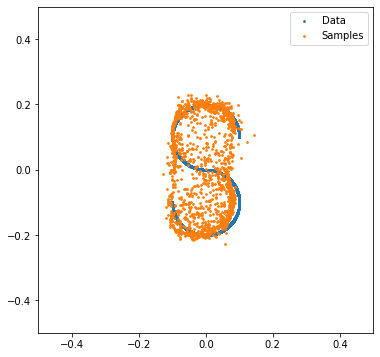

  0%|          | 0/1000 [00:00<?, ?it/s]

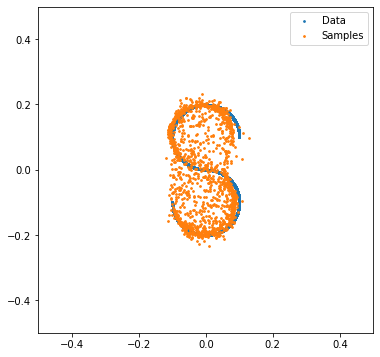

  0%|          | 0/1000 [00:00<?, ?it/s]

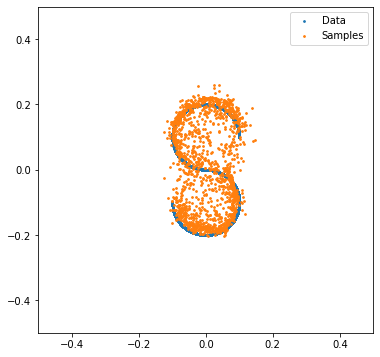

  0%|          | 0/1000 [00:00<?, ?it/s]

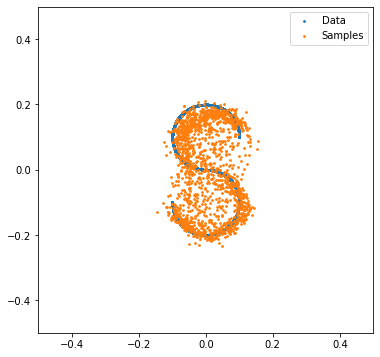

  0%|          | 0/1000 [00:00<?, ?it/s]

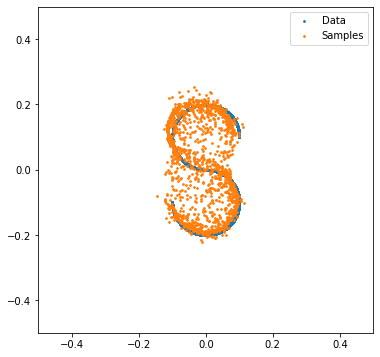

  0%|          | 0/1000 [00:00<?, ?it/s]

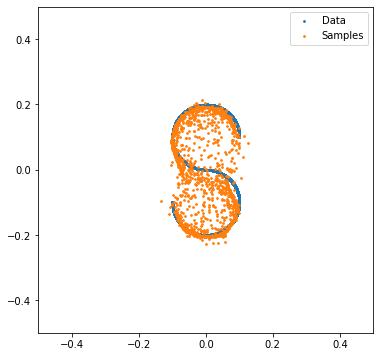

  0%|          | 0/1000 [00:00<?, ?it/s]

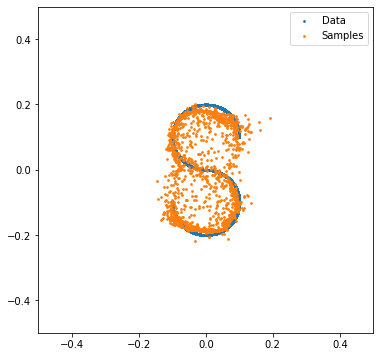

  0%|          | 0/1000 [00:00<?, ?it/s]

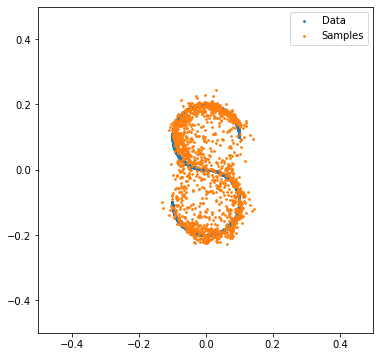

  0%|          | 0/1000 [00:00<?, ?it/s]

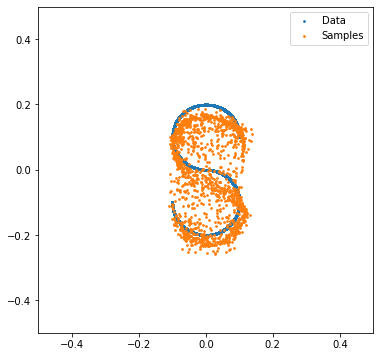

  0%|          | 0/1000 [00:00<?, ?it/s]

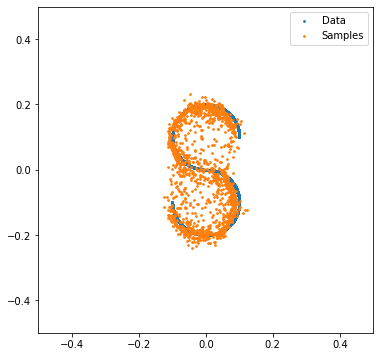

  0%|          | 0/1000 [00:00<?, ?it/s]

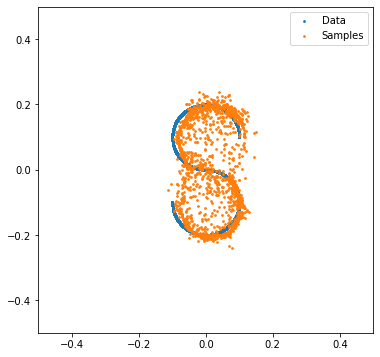

  0%|          | 0/1000 [00:00<?, ?it/s]

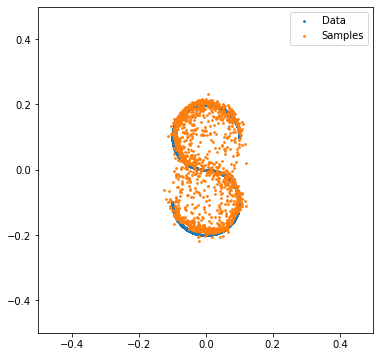

  0%|          | 0/1000 [00:00<?, ?it/s]

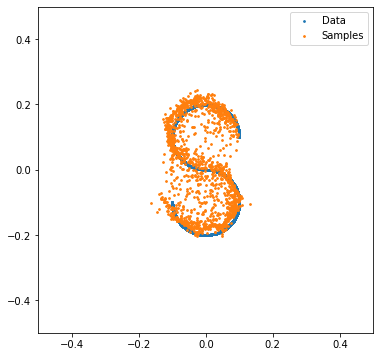

  0%|          | 0/1000 [00:00<?, ?it/s]

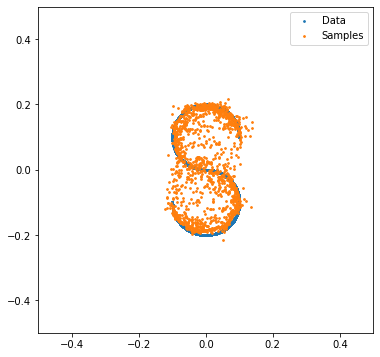

  0%|          | 0/1000 [00:00<?, ?it/s]

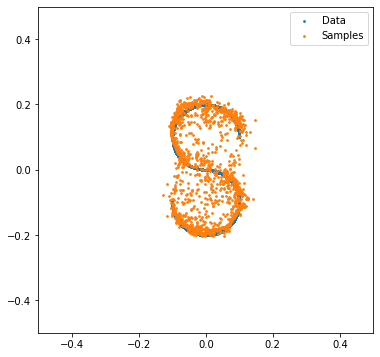

  0%|          | 0/1000 [00:00<?, ?it/s]

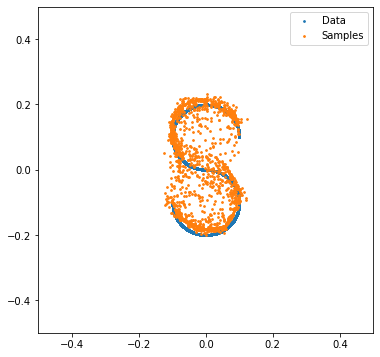

  0%|          | 0/1000 [00:00<?, ?it/s]

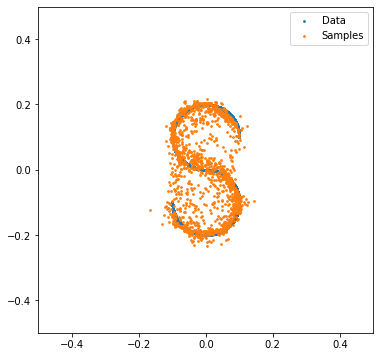

  0%|          | 0/1000 [00:00<?, ?it/s]

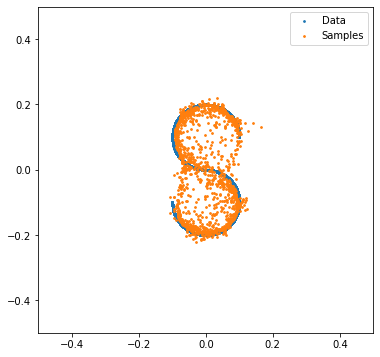

  0%|          | 0/1000 [00:00<?, ?it/s]

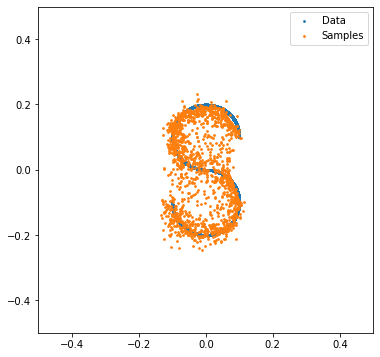

  0%|          | 0/1000 [00:00<?, ?it/s]

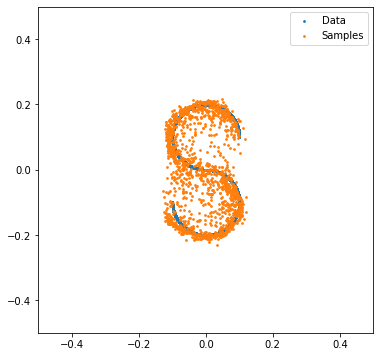

  0%|          | 0/1000 [00:00<?, ?it/s]

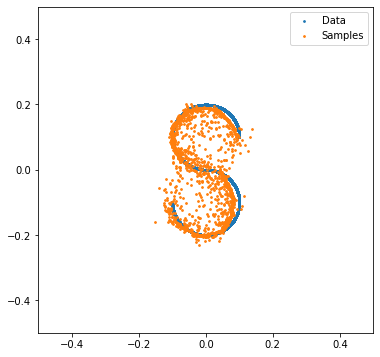

  0%|          | 0/1000 [00:00<?, ?it/s]

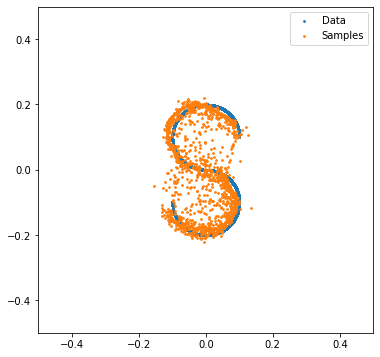

  0%|          | 0/1000 [00:00<?, ?it/s]

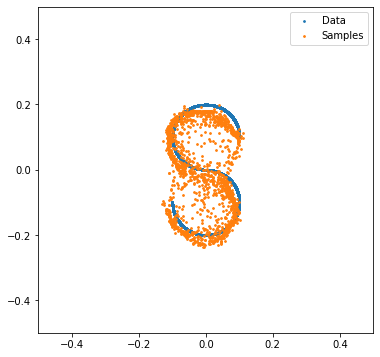

  0%|          | 0/1000 [00:00<?, ?it/s]

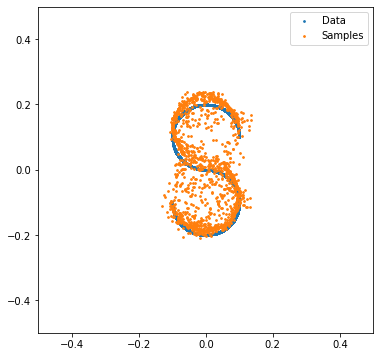

  0%|          | 0/1000 [00:00<?, ?it/s]

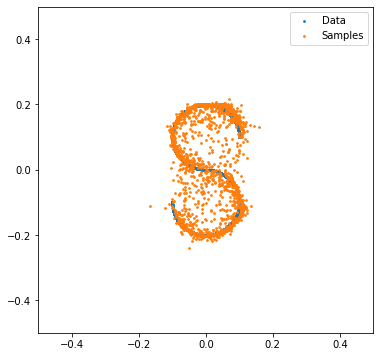

  0%|          | 0/1000 [00:00<?, ?it/s]

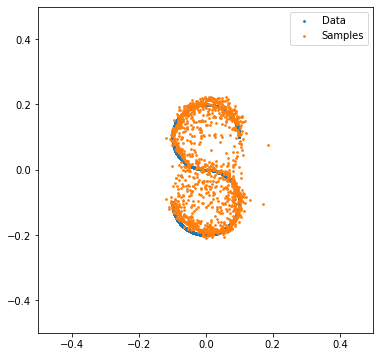

  0%|          | 0/1000 [00:00<?, ?it/s]

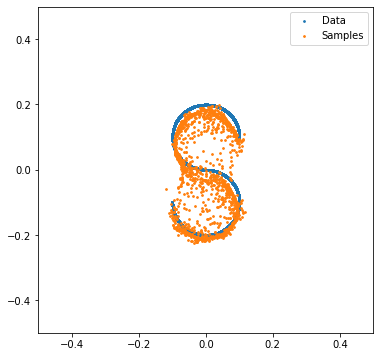

  0%|          | 0/1000 [00:00<?, ?it/s]

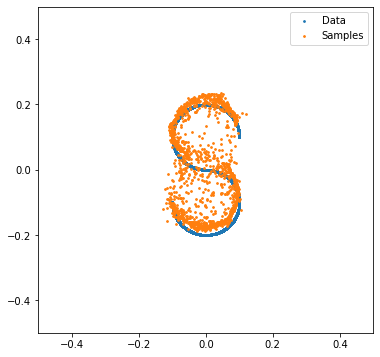

  0%|          | 0/1000 [00:00<?, ?it/s]

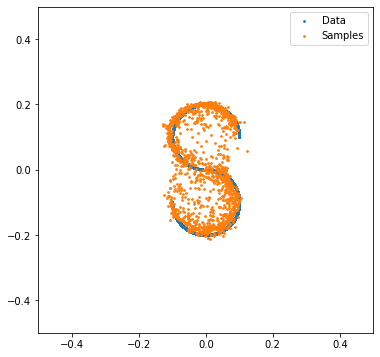

In [9]:
data = generate_dataset(10000, noise=0)
dataset = torch.utils.data.TensorDataset(torch.tensor(data, device=device))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)


optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x in dataloader:
    x = x[0].to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')
  if epoch % sample_interval == 0:
    samples = Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, device=device, batch_size=1500)
    samples = samples.cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.xlim(scatter_range)
    plt.ylim(scatter_range)
    plt.scatter(data[:, 0], data[:, 1], s=3, label='Data')
    plt.scatter(samples[:, 0], samples[:, 1], s=3, label='Samples')
    plt.legend()
    plt.show()

In [10]:

## Load the pre-trained checkpoint from disk.
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 2500 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples, imgs = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

/var/folders/n_/ykwl_b5n0gx9x4hp5z0fmvvr0000gn/T/ipykernel_96561/2707645364.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/n_/ykwl_b5n0gx9x4hp5z0fmvvr0000gn/T/ipykernel_96561/2707645364.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


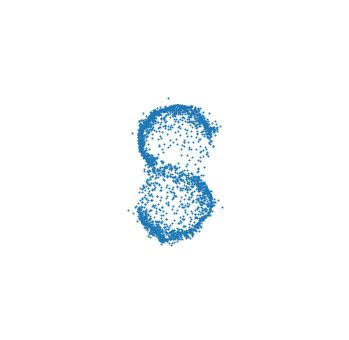

In [11]:
plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
plt.axis('off')
plt.scatter(samples[:, 0], samples[:, 1], s=1)

In [12]:
import io
from PIL import Image

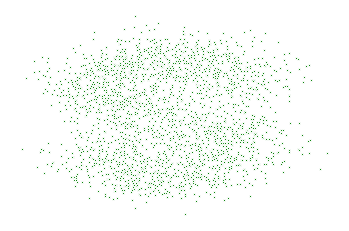

In [13]:
results = []
for i in range(num_steps):
    plt.clf()
    scatter_point = imgs[i].detach().cpu().numpy()
    scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

    scat = plt.scatter(scatter_x, scatter_y,color='green', edgecolor='white', s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg')
    img = Image.open(img_buf)
    results.append(img)
results[0].save("sde.gif",format='GIF',append_images=results,save_all=True,duration=10,loop=0)

This gif shows the progress of how the sampling works.  
![output](/output/sde/sde.gif)